In [3]:
! pip show xgboost --verbose

Name: xgboost
Version: 1.1.1
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: None
Author-email: None
License: Apache-2.0
Location: /Users/mash/.pyenv/versions/3.8.2/envs/basicwork/lib/python3.8/site-packages
Requires: scipy, numpy
Required-by: dask-xgboost
Metadata-Version: 2.1
Installer: pip
Classifiers:
  License :: OSI Approved :: Apache Software License
  Development Status :: 5 - Production/Stable
  Operating System :: OS Independent
  Programming Language :: Python
  Programming Language :: Python :: 3
  Programming Language :: Python :: 3.5
  Programming Language :: Python :: 3.6
  Programming Language :: Python :: 3.7
  Programming Language :: Python :: 3.8
Entry-points:


### Jason Brownlee's example
https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [4]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 1.1.1


In [5]:
# define model
model = XGBRegressor()

NameError: name 'XGBRegressor' is not defined

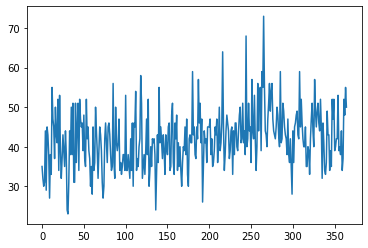

In [8]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('data/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

A persistence model can achieve a MAE of about 6.7 births when predicting the last 12 months. This provides a baseline in performance above which a model may be considered skillful.

Next, we can evaluate the XGBoost model on the dataset when making one-step forecasts for the last 12 months of data.

We will use only the previous 6 time steps as input to the model and default model hyperparameters, except we will change the loss to ‘reg:squarederror‘ (to avoid a warning message) and use a 1,000 trees in the ensemble (to avoid underlearning).

The complete example is listed below.

/Users/mash/.pyenv/versions/3.8.2/envs/basicwork/lib/python3.8/site-packages/xgboost/core.py:442: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2
MAE: 5.957


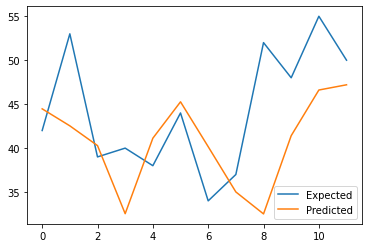

In [10]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('data/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

A line plot is created comparing the series of expected values and predicted values for the last 12 months of the dataset.

This gives a geometric interpretation of how well the model performed on the test set.

The example below demonstrates fitting a final XGBoost model on all available data and making a one-step prediction beyond the end of the dataset.

In [11]:
# finalize model and make a prediction for monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
series = read_csv('data/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34 37 52 48 55 50], Predicted: 42.708


Jason Brownlee's How to Develop Multi-Output Regression Models with Python, useful for multivariate time series construction
https://machinelearningmastery.com/multi-output-regression-models-with-python/

In [ ]:
reg = xgboost.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

https://www.kaggle.com/furiousx7/xgboost-time-series

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [15]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [16]:
pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [17]:
# Create time series features
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [18]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

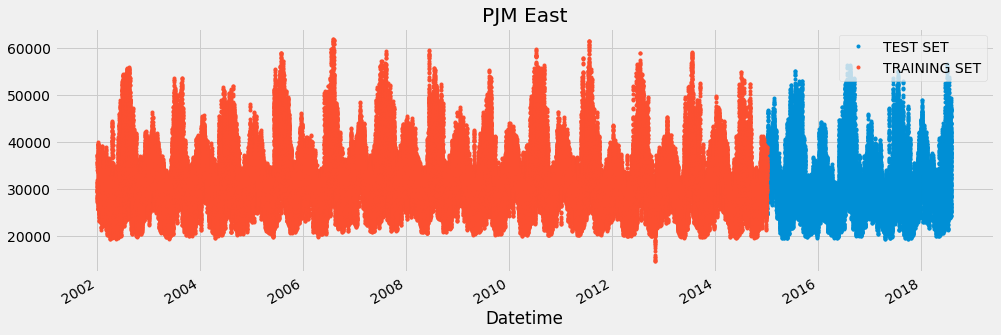

In [19]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [20]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [21]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,22,2,1,1,2014,1,1,1


In [22]:
y_train

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
                        ...   
2014-01-01 20:00:00    36193.0
2014-01-01 21:00:00    35601.0
2014-01-01 22:00:00    34242.0
2014-01-01 23:00:00    32215.0
2014-01-02 00:00:00    30159.0
Name: PJME_MW, Length: 113927, dtype: float64

In [24]:
# Create XGBoost model
reg = xgboost.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:23192.05859	validation_1-rmse:22274.67188
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:16422.16016	validation_1-rmse:15525.66797
[2]	validation_0-rmse:11739.36621	validation_1-rmse:10989.66211
[3]	validation_0-rmse:8542.61426	validation_1-rmse:7892.59082
[4]	validation_0-rmse:6395.35596	validation_1-rmse:5904.56592
[5]	validation_0-rmse:4993.31592	validation_1-rmse:4822.39941
[6]	validation_0-rmse:4106.51270	validation_1-rmse:4249.08594
[7]	validation_0-rmse:3587.12646	validation_1-rmse:3946.07861
[8]	validation_0-rmse:3263.06152	validation_1-rmse:3822.64941
[9]	validation_0-rmse:3082.67993	validation_1-rmse:3769.57251
[10]	validation_0-rmse:2983.51733	validation_1-rmse:3736.43115
[11]	validation_0-rmse:2867.11304	validation_1-rmse:3753.34082
[12]	validation_0-rmse:2788.34912	validation_1-rmse:3792.44849
[13]	validation_0-rmse:274

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

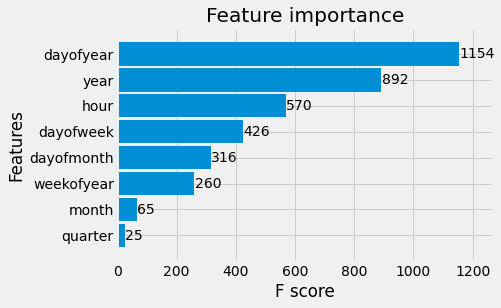

In [25]:
# Feature importances
_ = plot_importance(reg, height=0.9)

### Forecast on Test Set

In [28]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

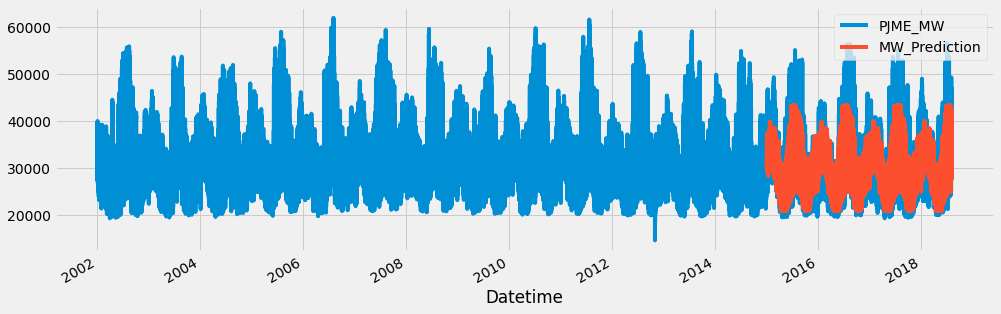

In [29]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

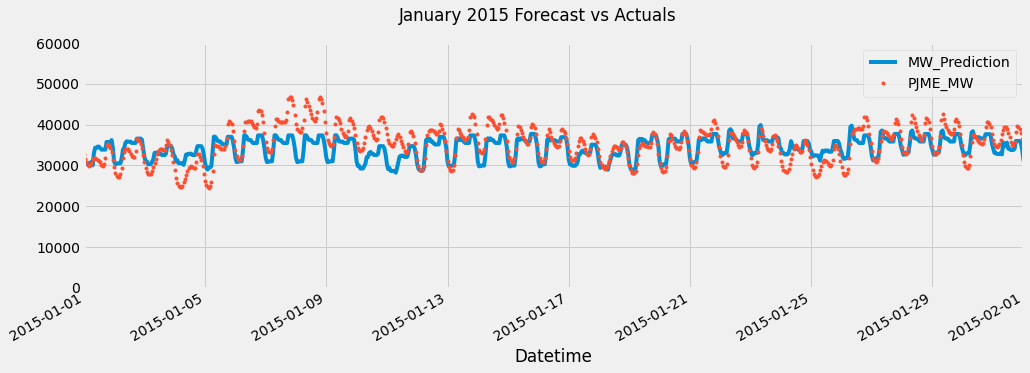

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

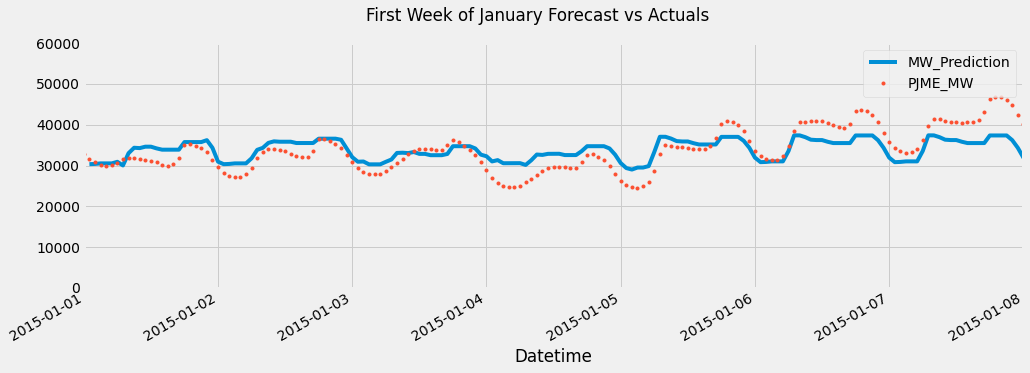

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

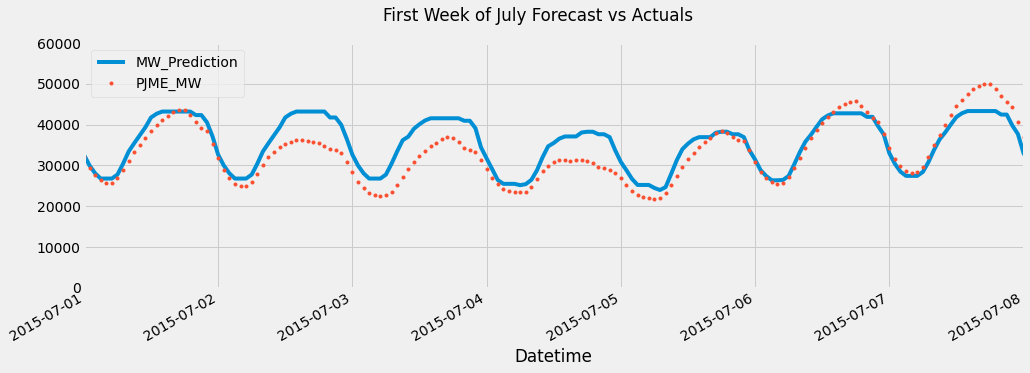

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Error Metrics on the Test Set 

In [33]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13960913.30565261

In [34]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2757.2169004982866

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.510847348494002

Our RMSE error is 13780445 <br>
Our MAE error is 2848.89<br>
Our MAPE error is 8.9%<br>

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost